# Barycenter DTW

In [94]:
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.interpolate import interp1d
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt


In [95]:
from ExtractShapelets import vector_accer, find_represt_shapelet

### Find representative shapelet

<AxesSubplot: >

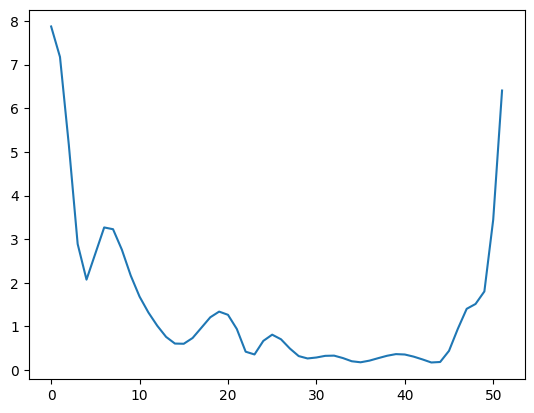

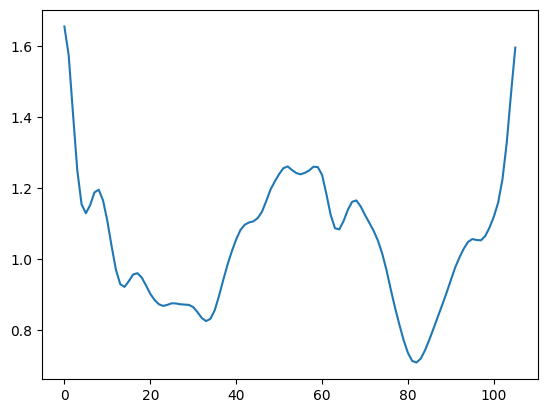

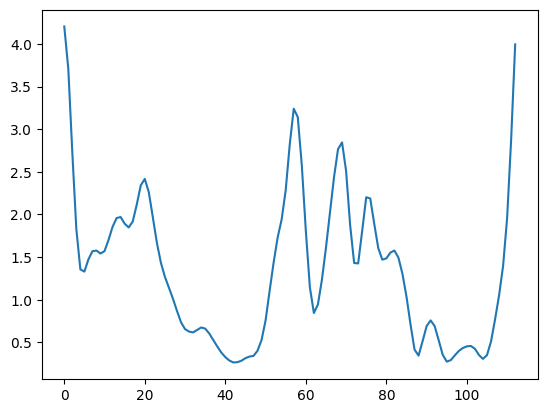

In [96]:
# Jump
zqw_jump = vector_accer("zqw\zqwjumpRAW.csv")['vm'][250:1800]
 # One cycle of walk and skip include 2 cycle of jump, so set the jump shapelet to 2 rounds
jump_rs = find_represt_shapelet(zqw_jump, min_dist=50, thres=0.99, max_dist=60)

# Walk
zqw_walk = vector_accer("zqw\zqwwalkRAW.csv")['vm'][0: 5400]
walk_rs = find_represt_shapelet(zqw_walk, min_dist=100, thres=0.95, max_dist=120)

# skip
zqw_skip = vector_accer("zqw\zqwskipRAW.csv")['vm'][0: 2700]
skip_rs = find_represt_shapelet(zqw_skip, min_dist=100, thres=0.8, max_dist=120)

pd.DataFrame(jump_rs).plot(legend=False)
pd.DataFrame(walk_rs).plot(legend=False)
pd.DataFrame(skip_rs).plot(legend=False)

In [104]:
# Function to resample a sequence to a target length
def resample_sequence(sequence, target_length):
    x = np.linspace(0, 1, len(sequence))
    f = interp1d(x, sequence, kind='linear', fill_value='extrapolate')
    x_new = np.linspace(0, 1, target_length)
    return f(x_new)

# Function to calculate the barycenter sequence using DTW
def barycenter_dtw(df1, df2):
    # Resample the longer sequence to the length of the shorter one
    max_length = max(len(df1), len(df2))
    df1_resampled = pd.DataFrame({col: resample_sequence(df1[col].values, max_length) for col in df1.columns})
    df2_resampled = pd.DataFrame({col: resample_sequence(df2[col].values, max_length) for col in df2.columns})

    # _, path = fastdtw(df1_resampled.values, df2_resampled.values, dist=euclidean)

    # Use the alignment path to calculate the barycenter sequence
    barycenter_seq = df1_resampled.values + df2_resampled.values
    barycenter_seq /= 2

    # Convert the barycenter sequence back to DataFrame
    barycenter_df = pd.DataFrame(barycenter_seq, columns=df1.columns)

    return barycenter_df

Barycenter DataFrame:


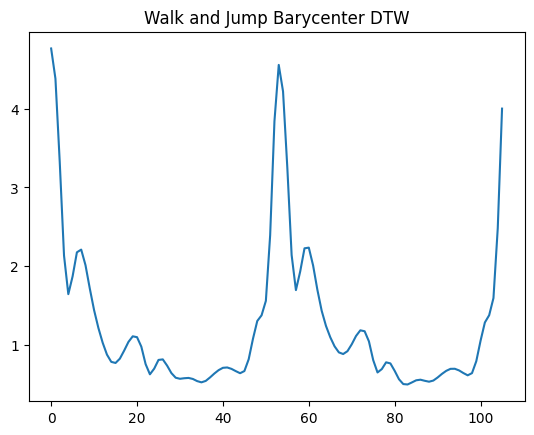

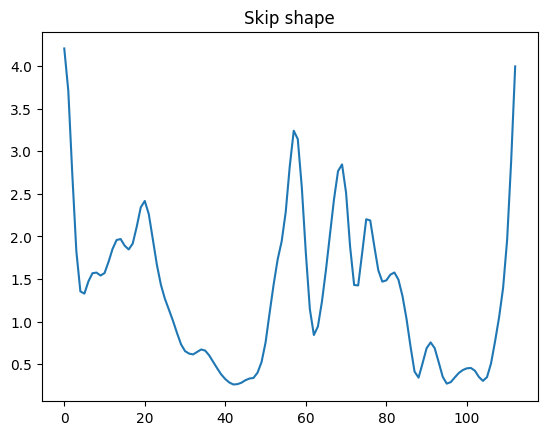

Distance of walk_jump_barycenter with skip is: 26.133046245162422
Distance of walk with skip is: 56.26958095753236
Distance of jump with skip is: 46.10194053307084


In [105]:
df1 = pd.DataFrame(walk_rs)
# double the jump shapelets, because one cycle of walk and skip is two cycle of jump
df2 = pd.concat([pd.DataFrame(jump_rs), pd.DataFrame(jump_rs)], ignore_index=True)
barycenter_df = barycenter_dtw(df1, df2)
print("Barycenter DataFrame:")
ax = barycenter_df.plot(legend=False)
ax.set_title('Walk and Jump Barycenter DTW')
ax = pd.DataFrame(skip_rs).plot(legend=False)
ax.set_title("Skip shape")
plt.show()

# Distance Comparison
distance, path = fastdtw(barycenter_df, pd.DataFrame(skip_rs), dist=euclidean)
print("Distance of walk_jump_barycenter with skip is:", distance)
distance, path = fastdtw(pd.DataFrame(walk_rs), pd.DataFrame(skip_rs), dist=euclidean)
print("Distance of walk with skip is:", distance)
distance, path = fastdtw(pd.DataFrame(jump_rs), pd.DataFrame(skip_rs), dist=euclidean)
print("Distance of jump with skip is:", distance)

## Evaluate the accuracy by sliding window

In [103]:
def shapelet_window_distance(barycenter_df, time_series, window_size):
    distances = []
    for i in range(len(time_series) - window_size + 1):
        window = time_series[i : i + window_size]
        window_df = pd.DataFrame(window)
        # Calculate DTW distance between the window and the shapelet
        distance, _ = fastdtw(window_df, barycenter_df, dist=euclidean)
        distances.append(distance)
    # Plot the original time series and the shapelet
    plt.figure(figsize=(12, 4))
    plt.plot(time_series, label="Time Series")
    plt.plot(np.arange(window_size) + np.argmax(distances), barycenter_df, label="Max_distance_Shapelet", linestyle="--")
    plt.plot(np.arange(window_size) + np.argmin(distances), barycenter_df, label="Min_distance_Shapelet", linestyle="--")
    plt.title("Sliding Window DTW Distance with Shapelet")
    plt.legend()
    plt.show()
    return distances


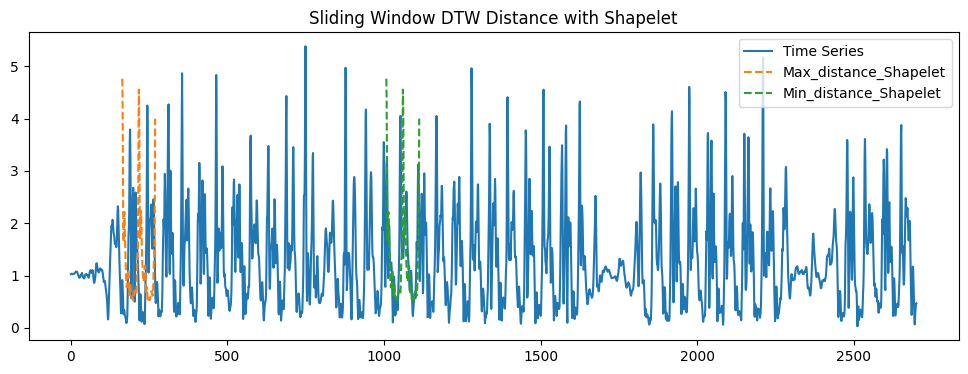

Mean of distance on skip is: 50.95763880748686
Min of distance on skip is: 25.15687423734477
Max of distance on skip is: 96.13482117740604


In [ ]:
# window_size is shapelet length
distances = shapelet_window_distance(barycenter_df, zqw_skip, window_size=len(barycenter_df))
avg_distance = np.mean(distances)
min_distance = np.min(distances)
max_distance = np.max(distances)
print("Mean of distance on skip is:", avg_distance)
print("Min of distance on skip is:", min_distance)
print("Max of distance on skip is:", max_distance)

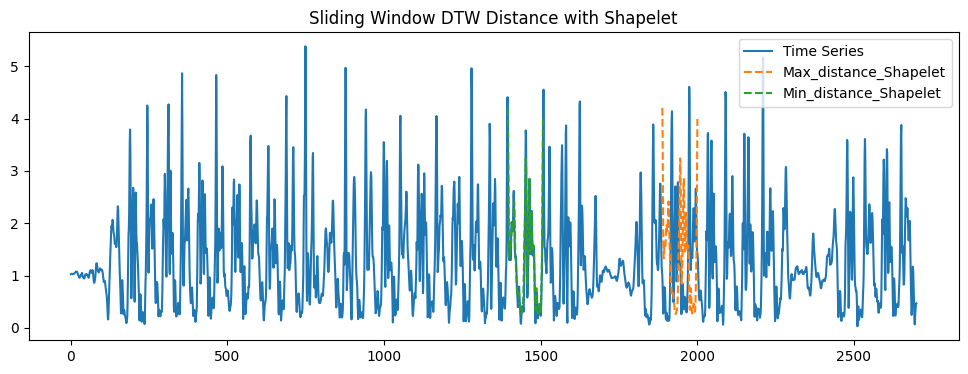

Mean of distance on skip is: 48.67674764282467
Min of distance on skip is: 12.684421240329764
Max of distance on skip is: 95.74642080676517


In [ ]:
# window_size is shapelet length
distances = shapelet_window_distance(pd.DataFrame(skip_rs), zqw_skip, window_size=len(skip_rs))
avg_distance = np.mean(distances)
min_distance = np.min(distances)
max_distance = np.max(distances)
print("Mean of distance on skip is:", avg_distance)
print("Min of distance on skip is:", min_distance)
print("Max of distance on skip is:", max_distance)

## Why the skip representative shapelet is less accurate on skip time series than barycenter walk_jump series?